In [1]:
##############################
# ARIA – Adaptive Running Intelligent Assistant
#
# This script launches a personalized running session using your runner profile.
#
# ✅ How it works:
# - You insert your data (age, weight, height), set your total distance (km), and target pace (min/km).
# - ARIA will dynamically adjust the session and stream music with matching BPM to support your pace and goals.
# - During the run, you can give live feedback by typing UP / DOWN / OK to influence the pacing:
#     - UP   → you're feeling strong → ARIA speeds up the BPM slightly
#     - DOWN → you're struggling     → ARIA slows things down to help you recover
#     - OK   → you're steady         → no change
# - If no feedback is given, ARIA assumes you're doing fine and keeps the current settings.
# - At the end, you'll be asked for a quick session rating (GOOD / OK / BAD) to track how it went for future runs.
#
# Let's get started!
#############################

##############################
# !!!! ISSUES !!!!
#
# - When the run ends, the live input box 
#   "💬 How do you feel? (UP / DOWN / OK):" 
#   remains visible even though the session is over. 
#   This can cause a crash or force a kernel restart 
#   if additional input is attempted.
#
# - After the run completes, ARIA asks 
#   "📝 How was the session overall? (GOOD / OK / BAD):". 
#   If no feedback is provided within the 4-second timeout, 
#   ARIA correctly skips, but the input box stays active, 
#   which can be confusing or cause the UI to hang. This will
#   not kill the kernel tho.
#
# I've tried to solve these UI/UX issues but couldn’t find 
# a clean solution without significantly altering the control 
# flow or abandoning standard input mechanisms.
##############################

##############################
# !!!! Testing Notes !!!!  
# - Code was written and tested successfully on JupyterLab.
# - On JupyterLite, multiple threads are not supported, so it does not work there.
# - On VSCode, it works but with a caveat:
#     * The live update of the running process only shows when user input or feedback is given,
#       instead of updating continuously regardless.
##############################

In [2]:
import threading
import time

class ARIARunner:
    def __init__(self, age, weight, height, aim_pace_min_per_km):
        self.age = age
        self.weight = weight
        self.height = height
        self.aim_pace = aim_pace_min_per_km
        self.max_hr = 220 - age
        self.zones = self._calculate_zones()
        
    def _calculate_zones(self):
        return {
            "Zone_1": (int(self.max_hr * 0.50), int(self.max_hr * 0.60)),
            "Zone_2": (int(self.max_hr * 0.60), int(self.max_hr * 0.70)),
            "Zone_3": (int(self.max_hr * 0.70), int(self.max_hr * 0.80)),
            "Zone_4": (int(self.max_hr * 0.80), int(self.max_hr * 0.90)),
            "Zone_5": (int(self.max_hr * 0.90), int(self.max_hr * 1.00)),
        }

music_library = [
    {"track": "Gentle Start", "bpm": 85, "energy": "low"},
    {"track": "Easy Flow", "bpm": 95, "energy": "low"},
    {"track": "Warm Rhythm", "bpm": 105, "energy": "moderate"},
    {"track": "Steady Beat", "bpm": 115, "energy": "moderate"},
    {"track": "Fat Burn Flow", "bpm": 125, "energy": "moderate"},
    {"track": "Aerobic Pulse", "bpm": 135, "energy": "high"},
    {"track": "Threshold Drive", "bpm": 145, "energy": "high"},
    {"track": "Power Push", "bpm": 155, "energy": "high"},
    {"track": "Sprint Surge", "bpm": 165, "energy": "very_high"},
    {"track": "Cool Breeze", "bpm": 90, "energy": "low"},
    {"track": "Recovery Rain", "bpm": 80, "energy": "low"},
]

def timed_input(prompt, timeout=4):
    """
    Prompts user for input with a timeout.
    Returns the input or None if time runs out.
    """
    user_input = [None]

    def get_input():
        try:
            user_input[0] = input(prompt).strip().upper()
        except EOFError:
            pass

    thread = threading.Thread(target=get_input)
    thread.daemon = True
    thread.start()
    thread.join(timeout)

    if thread.is_alive():
        return None
    return user_input[0]

def create_training_plan(runner, total_km):
    pace = runner.aim_pace
    zones = runner.zones
    
    def pace_adjust(base, delta):
        return round(base + delta / 60, 2)
    
    km_plan = [
        {"fraction": 0.1, "phase": "Warm_up", "zone": "Zone_1", "delta": 75, "purpose": "Prepare body"},
        {"fraction": 0.1, "phase": "Build", "zone": "Zone_2", "delta": 45, "purpose": "Ease in"},
        {"fraction": 0.5, "phase": "Aerobic_base", "zone": "Zone_2", "delta": 20, "purpose": "Build endurance"},
        {"fraction": 0.15, "phase": "Tempo", "zone": "Zone_3", "delta": -10, "purpose": "Race pace practice"},
        {"fraction": 0.1, "phase": "Strong_finish", "zone": "Zone_2", "delta": 0, "purpose": "Push at goal pace"},
        {"fraction": 0.05, "phase": "Cool_down", "zone": "Zone_1", "delta": 90, "purpose": "Recover"},
    ]
    
    current_km = 0
    plan = []
    
    for segment in km_plan:
        phase_kms = round(total_km * segment["fraction"], 2)
        start_km = round(current_km, 2)
        end_km = round(current_km + phase_kms, 2)
        zone = segment["zone"]
        base_bpm = zones[zone]
        
        if segment["phase"] == "Warm_up":
            bpm_range = (base_bpm[0], base_bpm[0] + 5)
        elif segment["phase"] == "Build":
            bpm_range = (base_bpm[0], base_bpm[0] + 5)
        elif segment["phase"] == "Tempo":
            bpm_range = (base_bpm[0], base_bpm[0] + 10)
        elif segment["phase"] == "Cool_down":
            bpm_range = (base_bpm[0] - 5, base_bpm[0] + 5)
        else:
            bpm_range = base_bpm
        
        plan.append({
            "km": f"{start_km}-{end_km}",
            "phase": segment["phase"],
            "target_zone": zone,
            "bpm_range": bpm_range,
            "target_pace": pace_adjust(pace, segment["delta"]),
            "purpose": segment["purpose"]
        })
        current_km = end_km
    
    return plan

def format_pace(decimal_pace):
    minutes = int(decimal_pace)
    seconds = int(round((decimal_pace - minutes) * 60))
    return f"{minutes}:{seconds:02d} min/km"

class ARIASession:
    
    def export_session_log(self):
        import pandas as pd
        return pd.DataFrame(self.session_log)
    
    def __init__(self, runner, plan, total_km):
        self.runner = runner
        self.plan = plan
        self.total_km = total_km
        self.feedback_lock = threading.Lock()
        self.feedback = None
        self.current_km = 0.0
        self.current_phase_index = 0
        self.session_feedback = []  # Initialize session feedback list
        self.feedback_active = True  # Flag to control feedback thread
        self.feedback_cutoff = total_km * 0.98  # 98% threshold
        self.input_thread_obj = None  # Store reference to input thread
        self.session_log = []  # To store log data for each interval
        
        segment = plan[0]
        self.music_state = {
            "bpm": segment["bpm_range"][0],
            "playlist": segment["phase"]
        }

    def input_thread(self):
        try:
            while True:
                # Check if we should stop
                if not self.feedback_active or self.current_km >= self.feedback_cutoff:
                    break

                # Print prompt right before input to ensure it stays "next to" the box
                user_input = input("💬 How do you feel? (UP / DOWN / OK): ").strip().upper()
                
                time.sleep(4)

                # Process only if still active
                if self.feedback_active and self.current_km < self.feedback_cutoff:
                    with self.feedback_lock:
                        self.feedback = user_input
                else:
                    break

        except (EOFError, KeyboardInterrupt):
            pass
        except Exception:
            pass
        
    def _clamp_pace(self, pace):
        pace_error = 3/100 # 3% error on the aim_pace
        lower = self.runner.aim_pace * (1 - pace_error)
        upper = self.runner.aim_pace * (1 + pace_error)
        return max(lower, min(pace, upper))

    def simulate_run(self):
        # Start input thread
        self.input_thread_obj = threading.Thread(target=self.input_thread, daemon=True)
        self.input_thread_obj.start()

        current_pace = self._clamp_pace(self.plan[0]["target_pace"])

        while self.current_km < self.total_km:
            segment = self.plan[self.current_phase_index]
            start_km, end_km = map(float, segment["km"].split("-"))

            print(f"\n📍 KM {self.current_km:.2f}: {segment['phase']} Phase", flush=True)
            print(f"   Target: {segment['target_zone']} ({segment['purpose']})", flush=True)
            print(f"   Target Pace: {format_pace(current_pace)}", flush=True)
            print(f"   🎵 Now Playing: {segment['phase']} ({self.music_state['bpm']} BPM)", flush=True)

            time.sleep(4)  # Simulate delay time between checkpoints

            # Handle feedback asynchronously (only if still active and before cutoff)
            if self.feedback_active and self.current_km < self.feedback_cutoff:
                with self.feedback_lock:
                    current_feedback = self.feedback  # Capture current feedback before clearing
                    if current_feedback == "UP":
                        current_pace = self._clamp_pace(max(3.0, current_pace - 0.1))
                        self.music_state["bpm"] += 10
                        print("   💪 Feeling strong! Speeding up.", flush=True)
                    elif current_feedback == "DOWN":
                        current_pace = self._clamp_pace(current_pace + 0.1)
                        self.music_state["bpm"] = max(80, self.music_state["bpm"] - 10)
                        print("   🧘 Slowing down for recovery.", flush=True)
                    elif current_feedback == "OK":
                        print("   ✅ Staying steady.", flush=True)
                    self.feedback = None  # Clear feedback
            else:
                current_feedback = None

            # Estimate time from pace and segment distance
            segment_duration_min = (0.15 * self.total_km) * current_pace
            time_elapsed = sum([entry["segment_duration_min"] for entry in self.session_log]) if self.session_log else 0

            # Store log data
            self.session_log.append({
                "km": round(self.current_km, 2),
                "time_min": round(time_elapsed, 2),
                "pace": round(current_pace, 2),
                "bpm": self.music_state["bpm"],
                "zone": segment["target_zone"],
                "feedback": current_feedback or "NONE",
                "segment_duration_min": segment_duration_min
            })

            self.current_km += 0.1 * self.total_km

            if self.current_km >= end_km and self.current_phase_index < len(self.plan) - 1:
                self.current_phase_index += 1
                next_segment = self.plan[self.current_phase_index]
                self.music_state["bpm"] = next_segment["bpm_range"][0]
                self.music_state["playlist"] = next_segment["phase"]
                # Clamp pace for the next segment
                current_pace = self._clamp_pace(next_segment["target_pace"])

        # Ensure feedback is completely disabled at the end
        self.feedback_active = False

        # Give the input thread time to terminate cleanly
        time.sleep(4)

        print("\n🏁 Session Complete! Great job! 🎉")

        # Ask for session-level feedback with timeout
        session_feedback = timed_input("📝 How was the session overall? (GOOD / OK / BAD): ", timeout=6)

        if session_feedback:
            print(f"📌 Thanks! Your feedback: {session_feedback}", flush=True)
            self.session_feedback.append({
                "distance": self.total_km,
                "feedback": session_feedback,
                "final_bpm": self.music_state["bpm"]
            })
        else:
            print("⏳ No feedback received. Skipping for later.", flush=True)
            
def decimal_to_minsec(x, pos=None):
    minutes = int(x)
    seconds = int(round((x - minutes) * 60))
    return f"{minutes}:{seconds:02d}"

def plot_session(df, target_pace=None):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    import numpy as np
    from matplotlib.ticker import MultipleLocator

    df["feedback"] = df["feedback"].str.upper()
    fig, ax1 = plt.subplots(figsize=(14, 7))
    fig.patch.set_facecolor('white')

    font_size = 15

    ax1.set_xlabel("Distance [km]", fontsize=font_size, fontweight='bold')
    ax1.set_ylabel("Pace [min/km]", fontsize=font_size, color="tab:blue", fontweight='bold')
    ax2 = ax1.twinx()
    ax2.set_ylabel("Music BPM", fontsize=font_size, color="tab:red", fontweight='bold')

    # Plot actual pace
    ax1.plot(df["km"], df["pace"], marker='o', markersize=8, color="tab:blue")

    # Plot running mean pace
    df["running_mean_pace"] = df["pace"].expanding().mean()
    ax1.plot(df["km"], df["running_mean_pace"], linestyle='-.', linewidth=2, color="tab:cyan", label="Mean Pace")

    # Plot target pace line if provided
    if target_pace:
        ax1.axhline(y=target_pace, linestyle='--', color='gray', linewidth=2, label=f"Target Pace: {decimal_to_minsec(target_pace)}")

    # Plot BPM
    ax2.plot(df["km"], df["bpm"], marker='s', markersize=8, linestyle='--', color="tab:red")

    # Pace format as mm:ss
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(decimal_to_minsec))

    ax1.set_xlim(-0.1, df["km"].max() + 0.1)
    
    ax1.tick_params(axis="both", labelsize=font_size, colors="black")
    ax2.tick_params(axis="y", labelsize=font_size, colors="black")

    ax1.grid(which='both', axis='x', linestyle=':', linewidth=0.7, alpha=0.7)
    ax1.xaxis.set_major_locator(MultipleLocator(0.5))
    ax1.xaxis.set_minor_locator(MultipleLocator(0.1))

    plt.title("Run Session Overview", fontsize=font_size + 2, fontweight='bold')
    ax1.legend(loc="lower center", fontsize=font_size - 1)
    plt.show()


In [4]:
# User Profile Configuration
user_profile = {
    "age": 28, # yrs
    "weight": 72, # kg
    "height": 177, # cm
    "aim_pace_min_per_km": 6.0, # min/km, ARIA is aiming for your goal pm your desire percentage
    "total_km": 3.0 # km
}

In [5]:
# 🏃 Example Run
if __name__ == "__main__":
    # Create a runner using the user profile
    runner = ARIARunner(
        age=user_profile["age"],
        weight=user_profile["weight"],
        height=user_profile["height"],
        aim_pace_min_per_km=user_profile["aim_pace_min_per_km"]
    )
    
    # Create training plan
    plan = create_training_plan(runner, user_profile["total_km"])
    
    # Start session
    session = ARIASession(runner, plan, user_profile["total_km"])
    session.simulate_run()
    df = session.export_session_log()


📍 KM 0.00: Warm_up Phase
   Target: Zone_1 (Prepare body)
   Target Pace: 6:11 min/km
   🎵 Now Playing: Warm_up (96 BPM)

📍 KM 0.30: Build Phase
   Target: Zone_2 (Ease in)
   Target Pace: 6:11 min/km
   🎵 Now Playing: Build (115 BPM)


💬 How do you feel? (UP / DOWN / OK):  up



📍 KM 0.60: Aerobic_base Phase
   Target: Zone_2 (Build endurance)
   Target Pace: 6:11 min/km
   🎵 Now Playing: Aerobic_base (115 BPM)
   💪 Feeling strong! Speeding up.

📍 KM 0.90: Aerobic_base Phase
   Target: Zone_2 (Build endurance)
   Target Pace: 6:05 min/km
   🎵 Now Playing: Aerobic_base (125 BPM)

📍 KM 1.20: Aerobic_base Phase
   Target: Zone_2 (Build endurance)
   Target Pace: 6:05 min/km
   🎵 Now Playing: Aerobic_base (125 BPM)


💬 How do you feel? (UP / DOWN / OK):  ok



📍 KM 1.50: Aerobic_base Phase
   Target: Zone_2 (Build endurance)
   Target Pace: 6:05 min/km
   🎵 Now Playing: Aerobic_base (125 BPM)
   ✅ Staying steady.

📍 KM 1.80: Aerobic_base Phase
   Target: Zone_2 (Build endurance)
   Target Pace: 6:05 min/km
   🎵 Now Playing: Aerobic_base (125 BPM)

📍 KM 2.10: Tempo Phase
   Target: Zone_3 (Race pace practice)
   Target Pace: 5:50 min/km
   🎵 Now Playing: Tempo (134 BPM)

📍 KM 2.40: Tempo Phase
   Target: Zone_3 (Race pace practice)
   Target Pace: 5:50 min/km
   🎵 Now Playing: Tempo (134 BPM)

📍 KM 2.70: Strong_finish Phase
   Target: Zone_2 (Push at goal pace)
   Target Pace: 6:00 min/km
   🎵 Now Playing: Strong_finish (115 BPM)


💬 How do you feel? (UP / DOWN / OK):  ok



🏁 Session Complete! Great job! 🎉


📝 How was the session overall? (GOOD / OK / BAD):  good


📌 Thanks! Your feedback: GOOD


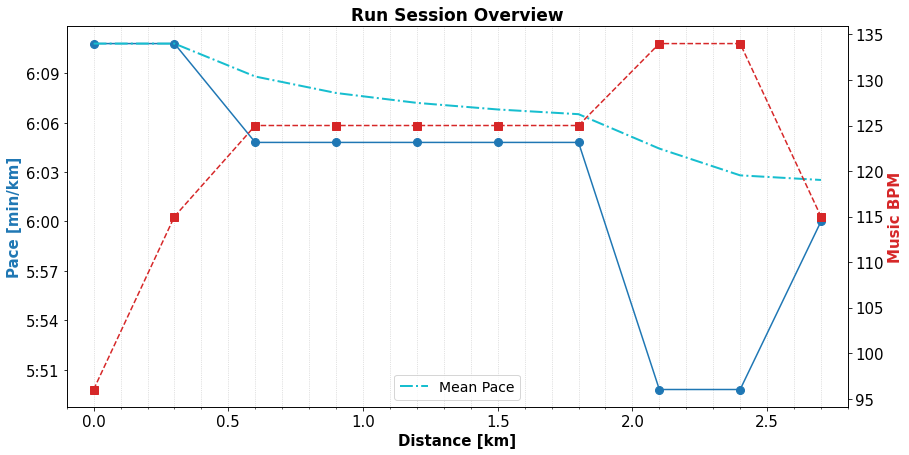

Target avg pace: 6:00 [min/km]
Actual avg pace: 6:03 [min/km]


In [6]:
plot_session(df)

mean_pace = df["pace"].mean()
print(f"Target avg pace: {decimal_to_minsec(user_profile['aim_pace_min_per_km'])} [min/km]")
print(f"Actual avg pace: {decimal_to_minsec(mean_pace)} [min/km]")

In [7]:
print('end')

end
